In [193]:
import numpy as np
import gym
from gym.core import ObservationWrapper
import matplotlib.pyplot as plt
import seaborn as sns
from random import choice
sns.set()

%matplotlib inline

In [194]:
class Q_Learning_Agent:
    def __init__(self, alpha, alpha_decay, epsilon, epsilon_decay, gamma, n_actions):
        
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.possible_actions = list(range(n_actions))
        self.epsilon_decay = epsilon_decay
        self.alpha_decay = alpha_decay
        
    def get_value_of_state(self, s):
        
        v = -1 * np.inf
        
        for ac in self.possible_actions:
            ac_val = self.Qvalues[s][ac]
            if ac_val > v:
                v = ac_val

        return v
        
    def update(self, s, a, r, s_prime):
        
        q_sa = self.Qvalues[s][a]
        self.Qvalues[s][a] = q_sa + self.alpha * (r + self.gamma * self.get_value_of_state(s_prime) - q_sa)
        
    def best_action(self, s):
        
        s_action = None
        best_q = -1 * np.inf
        
        for ac in self.possible_actions:
            ac_val = self.Qvalues[s][ac]
            if ac_val > best_q:
                best_q = ac_val
                s_action = ac
                
        return s_action
    
    def select_action(self, state):
        
        toss = np.random.uniform()
        
        if toss < self.epsilon:
            chosen_action = np.random.choice(self.possible_actions)
        else:
            chosen_action = self.best_action(state)
            
            
        self.epsilon = self.epsilon * self.epsilon_decay
        self.alpha = self.alpha * self.alpha_decay

        return chosen_action
        

In [199]:
class Dyna_Q_Agent:
    def __init__(self, alpha, alpha_decay, epsilon, epsilon_decay, gamma, planning_steps, n_actions):
        
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.model = defaultdict()
        self.possible_actions = list(range(n_actions))
        self.epsilon_decay = epsilon_decay
        self.alpha_decay = alpha_decay
        self.planning_steps = planning_steps
        
    def get_value_of_state(self, s):
        
        v = -1 * np.inf
        
        for ac in self.possible_actions:
            ac_val = self.Qvalues[s][ac]
            if ac_val > v:
                v = ac_val

        return v
        
    def update(self, s, a, r, s_prime):
        
        q_sa = self.Qvalues[s][a]
        self.Qvalues[s][a] = q_sa + self.alpha * (r + self.gamma * self.get_value_of_state(s_prime) - q_sa)
        
        #update the model
        
    def update_model(self, s, a, r, s_prime):
        self.model[(s,a)] = (r, s_prime)
        
    def best_action(self, s):
        
        s_action = None
        best_q = -1 * np.inf
        
        for ac in self.possible_actions:
            ac_val = self.Qvalues[s][ac]
            if ac_val > best_q:
                best_q = ac_val
                s_action = ac
                
        return s_action
    
    def select_action(self, state):
        
        toss = np.random.uniform()
        
        if toss < self.epsilon:
            chosen_action = np.random.choice(self.possible_actions)
        else:
            chosen_action = self.best_action(state)
            
            
        self.epsilon = self.epsilon * self.epsilon_decay
        self.alpha = self.alpha * self.alpha_decay
        
        if len(self.model.keys()) > self.planning_steps:
            #Do the planning steps:
            imaginary_samples = random.sample(list(self.model.keys()),self.planning_steps)
            for i in range(self.planning_steps):
                imag_s, imag_a = imaginary_samples[i]
                imag_r, imag_s_prime = self.model[imaginary_samples[i]]
                
                self.update(imag_s, imag_a, imag_r, imag_s_prime)
            

        return chosen_action
        

In [196]:
class Trial:
    
    def __init__(self, env, agent, episodes, max_steps):
        
        self.env = env
        self.agent = agent
        self.episodes = episodes
        self.max_steps = max_steps
        self.returns = []
        
    def interact(self):
        
        for j in range(self.episodes):
            obs = self.env.reset()
            treturn = 0

            for i in range(self.max_steps):
                a = self.agent.select_action(obs)

                next_state, r, done, info = self.env.step(a)

                self.agent.update(obs, a, r, next_state)
                
                if isinstance(agent, Dyna_Q_Agent):
                    self.agent.update_model(obs, a, r, next_state)                   

                obs = next_state
                treturn += r

                if done:
                    break
                
            self.returns.append(treturn)
            
        return self.returns
        
        
        

In [358]:
class Binarizer(ObservationWrapper):

    def observation(self, state):

        # state = <round state to some amount digits.>
        # hint: you can do that with round(x,n_digits)
        # you will need to pick a different n_digits for each dimension
        state[0] = np.round(state[0], 0)
        state[1] = np.round(state[1], 0)
        state[2] = np.round(state[2], 2)
        state[3] = np.round(state[3], 1)

        return tuple(state)

In [382]:
# Number of experiments - For average and standard deviation

n_exp = 10
episodes = 3000
max_steps = 10000
total_return  = np.zeros(episodes,)

for i in range(n_exp):
    
    env = Binarizer(gym.make("CartPole-v0"))
    agent = Q_Learning_Agent(alpha=0.5, alpha_decay=0.99999, epsilon=0.4, epsilon_decay = 0.99999 ,gamma=0.999, n_actions= env.action_space.n)
    
    T = Trial(env=env, agent=agent, episodes=episodes, max_steps=max_steps)    
    current_return = np.array(T.interact())
    total_return =  total_return + current_return
    
average_return_q = total_return/n_exp

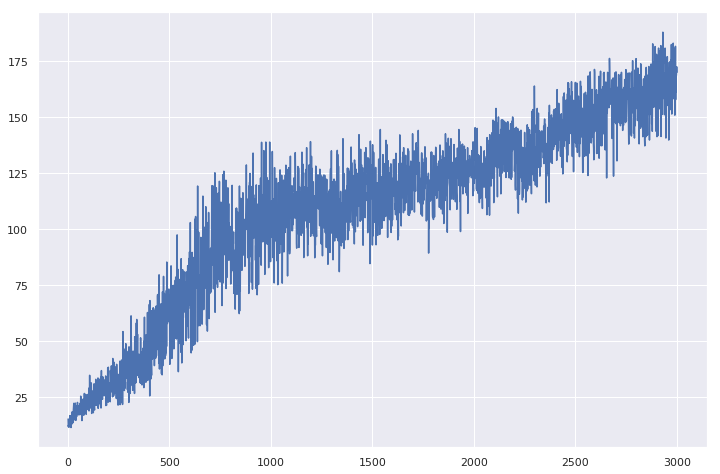

In [383]:
plt.figure(figsize=(12,8))
plt.plot(range(1, episodes + 1), average_return_q)

In [380]:
# Number of experiments - For average and standard deviation

n_exp = 10
episodes = 3000
max_steps = 10000
total_return  = np.zeros(episodes,)

for i in range(n_exp):
    
    env = Binarizer(gym.make("CartPole-v0"))
    agent = Dyna_Q_Agent(alpha=0.5, alpha_decay=0.9999 , epsilon=0.4, epsilon_decay = 0.99999 ,gamma=0.999, planning_steps=20, n_actions= env.action_space.n)
    
    T = Trial(env=env, agent=agent, episodes=episodes, max_steps=max_steps)    
    current_return = np.array(T.interact())
    total_return =  total_return + current_return
    
average_return_dyna = total_return/n_exp

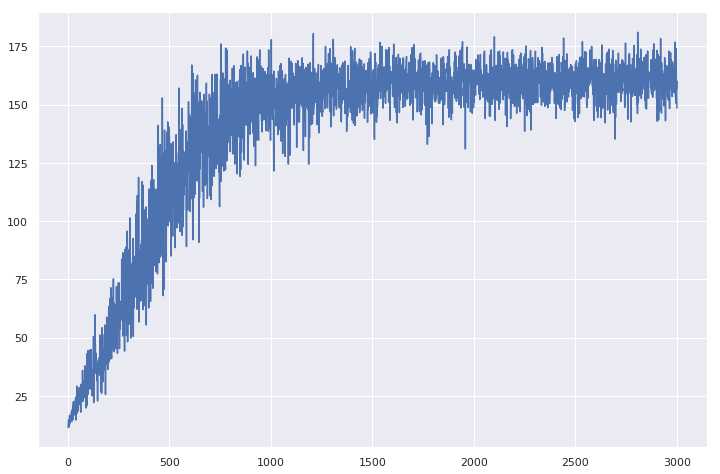

In [381]:
plt.figure(figsize=(12,8))
plt.plot(range(1, episodes + 1), average_return_dyna)

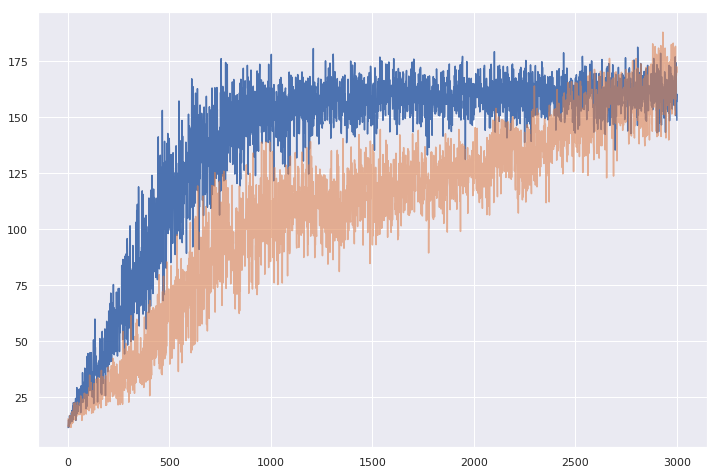

In [384]:
plt.figure(figsize=(12,8))
plt.plot(range(1, episodes + 1), average_return_dyna)
plt.plot(range(1, episodes + 1), average_return_q, alpha = 0.6)

In [311]:
len(agent.Qvalues)

1218

In [367]:
agent.alpha

0.005430251693643021

In [261]:
np.round(1.2222,0)

1.0